In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import librosa
import os

In [4]:
data_path = "/mnt/c/Users/divij/Jupyter_Notebooks/GTZAN/Data/genres_original"
genres = os.listdir(data_path)

#Load and preprocess audio data

In [5]:
X = []
y = []

for genre in os.listdir(data_path):
    genre_path = os.path.join(data_path, genre)
    if not os.path.isdir(genre_path):
        continue

    for file in os.listdir(genre_path):
        file_path = os.path.join(genre_path, file)
        try:
            signal, sr = librosa.load(file_path, sr=22050)
            mfccs = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=13)
            mfccs_mean = np.mean(mfccs.T, axis=0)
            X.append(mfccs_mean)
            y.append(genre)
        except Exception as e:
            print(f"Skipping {file} due to error: {e}")

# convert to numpy arrays AFTER the loop finishes
X = np.array(X)
y = np.array(y)
print("✅ Feature extraction complete! Shapes:", X.shape, y.shape)

/tmp/ipykernel_493/1368436875.py:12: UserWarning: PySoundFile failed. Trying audioread instead.
  signal, sr = librosa.load(file_path, sr=22050)
/home/divij1524/miniconda3/envs/tfgpu/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Skipping jazz.00054.wav due to error: 
✅ Feature extraction complete! Shapes: (999, 13) (999,)


#Train-test split

In [6]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Encode genre names to integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Convert integer labels to one-hot encoding
y_categorical = to_categorical(y_encoded)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, random_state=42)

print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("Classes:", label_encoder.classes_)

X_train: (799, 13)
y_train: (799, 10)
Classes: ['blues' 'classical' 'country' 'disco' 'hiphop' 'jazz' 'metal' 'pop'
 'reggae' 'rock']


# Building the neural Network

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

model = Sequential([
    Dense(256, activation='relu', input_shape=(X.shape[1],)),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(len(genres), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

/home/divij1524/miniconda3/envs/tfgpu/lib/python3.12/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1761300197.249528     493 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1765 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37,770 (147.54 KB)

 Trainable params: 37,770 (147.54 KB)

 Non-trainable params: 0 (0.00 B)

# Training the model

In [8]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',   # watch validation loss
    patience=10,          # stop if no improvement for 10 epochs
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=200,           # it will stop earlier if needed
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/200


I0000 00:00:1761300434.902336    1290 service.cc:152] XLA service 0x759f900174c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1761300434.902375    1290 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2025-10-24 15:37:14.969462: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1761300435.199974    1290 cuda_dnn.cc:529] Loaded cuDNN version 90101


24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1190 - loss: 21.5508 

I0000 00:00:1761300436.831607    1290 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.1209 - loss: 21.2981

2025-10-24 15:37:18.933780: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_68', 4 bytes spill stores, 4 bytes spill loads



25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 162ms/step - accuracy: 0.1665 - loss: 15.2329 - val_accuracy: 0.2950 - val_loss: 3.8248
Epoch 2/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2203 - loss: 5.9845 - val_accuracy: 0.3150 - val_loss: 2.2907
Epoch 3/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2228 - loss: 3.3370 - val_accuracy: 0.2400 - val_loss: 2.1055
Epoch 4/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2240 - loss: 2.5034 - val_accuracy: 0.2400 - val_loss: 2.1543
Epoch 5/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2453 - loss: 2.2511 - val_accuracy: 0.2600 - val_loss: 2.1425
Epoch 6/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2578 - loss: 2.1553 - val_accuracy: 0.2800 - val_loss: 2.1119
Epoch 7/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2591 - loss: 2.1255 - val_accuracy: 0.3200 - val_loss: 2.0241
Epoch 8/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2616 - loss: 2.0734 - val_accuracy: 0.2600 - val_loss: 

# Accuracy and loss graph

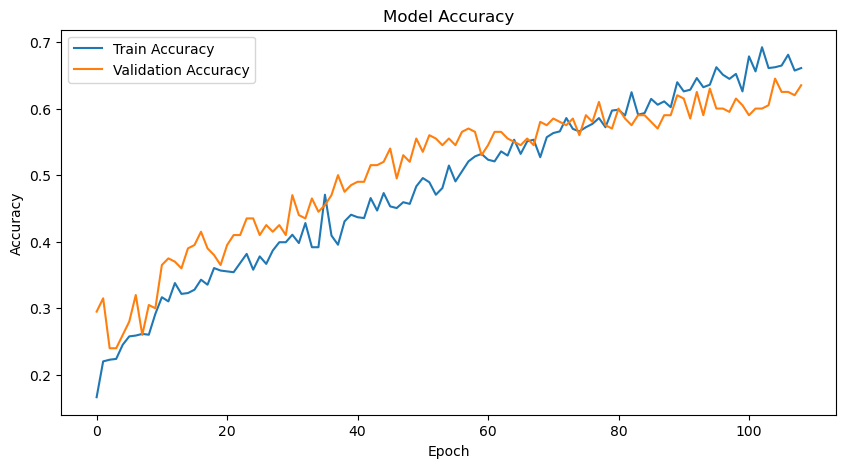

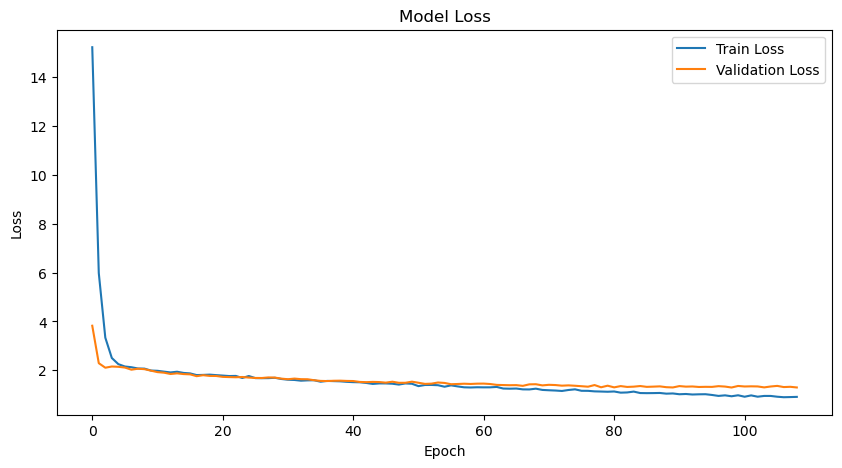

In [9]:
import matplotlib.pyplot as plt

# Accuracy plot
plt.figure(figsize=(10,5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss plot
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step


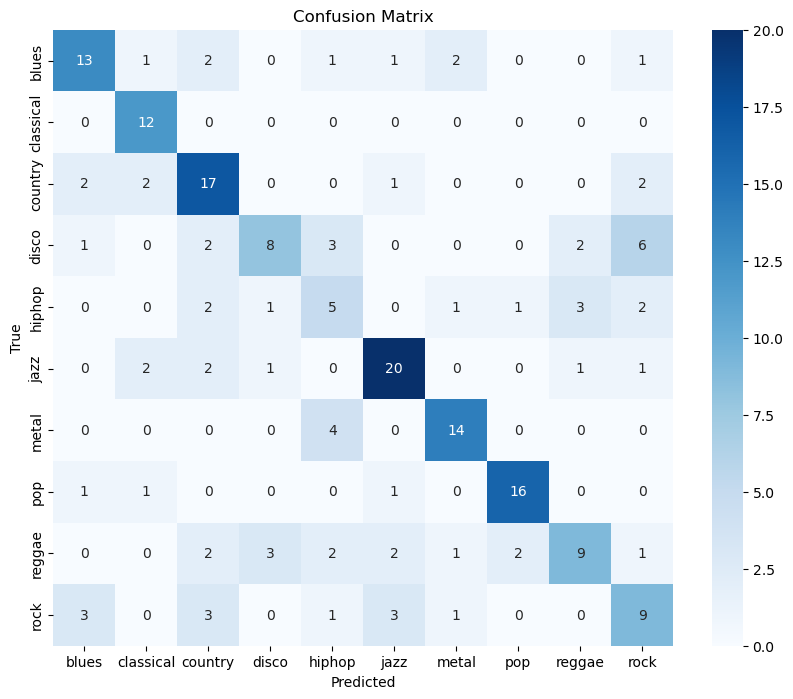

              precision    recall  f1-score   support

       blues       0.65      0.62      0.63        21
   classical       0.67      1.00      0.80        12
     country       0.57      0.71      0.63        24
       disco       0.62      0.36      0.46        22
      hiphop       0.31      0.33      0.32        15
        jazz       0.71      0.74      0.73        27
       metal       0.74      0.78      0.76        18
         pop       0.84      0.84      0.84        19
      reggae       0.60      0.41      0.49        22
        rock       0.41      0.45      0.43        20

    accuracy                           0.61       200
   macro avg       0.61      0.62      0.61       200
weighted avg       0.62      0.61      0.61       200



In [10]:
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=genres, yticklabels=genres)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Detailed report
print(classification_report(y_true, y_pred_classes, target_names=genres))
